# Historical Ellsworth (1984-2020)

In [1]:
import __init__
import scripts.config as config
import numpy as np
import pandas as pd
import tempfile
import datetime
import ipywidgets as widgets
from ipywidgets import interact
from natsort import natsorted
import os
from sklearn.metrics import mean_squared_error, r2_score
from matplotlib.font_manager import FontProperties
import seaborn as sns
# import matplotlib as mpl
import matplotlib.pyplot as plt
import importlib
from pathlib import Path
import itertools
from functools import reduce
from statsmodels.iolib.smpickle import load_pickle
import statsmodels.api as sm

In [2]:
# Plotting parameters

XSMALL_SIZE = 6
SMALL_SIZE = 7
MEDIUM_SIZE = 9
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams['figure.dpi'] = 120
export_dpi = 220

In [3]:
gcms = ['canesm2_RCP85', 'ccsm4_RCP85', 'giss_e2_h_RCP85', 'noresm1_m_RCP85', 'PRISM']
sim_start = pd.to_datetime('01-01-1984')
sim_end = pd.to_datetime('12-31-2020')

# Output figure folder
out_dir = config.data_path.parents[0] / 'figs' / 'sims_{}_{}'.format(sim_start.year % 100, sim_end.year % 100)
try:
    out_dir.mkdir(parents=True)
except FileExistsError:
    pass

# Import driver data
temp_files = []
precip_files = []
for gcm in [x for x in gcms if x!='PRISM']:
    temp_file_path = config.velma_data / 'temp' / '{}_{}_{}_temp.csv'.format(gcm, 
                                                                             sim_start.year % 100,
                                                                             sim_end.year % 100)
    temp_file = pd.read_csv(temp_file_path, names=['temp'])
    temp_file.index = pd.date_range(sim_start, sim_end)
    temp_files.append(temp_file)
    
    precip_file_path = config.velma_data / 'precip' / '{}_{}_{}_ppt.csv'.format(gcm, 
                                                                                sim_start.year % 100, 
                                                                                sim_end.year % 100)
    precip_file = pd.read_csv(precip_file_path, names=['precip'])
    precip_file.index = pd.date_range(sim_start, sim_end)
    precip_files.append(precip_file)


# PRISM data has a different naming convention because the precip is gauge/PRISM average
temp_file_path = config.velma_data / 'temp' / 'PRISM_{}_{}_temp.csv'.format(sim_start.year % 100, 
                                                                            sim_end.year % 100)
temp_file = pd.read_csv(temp_file_path, names=['temp'])
temp_file.index = pd.date_range(sim_start, sim_end)
temp_files.append(temp_file)

precip_file_path = config.velma_data / 'precip' / 'PRISM_{}_{}_gauge_avg_ppt.csv'.format(sim_start.year % 100, 
                                                                                         sim_end.year % 100)
precip_file = pd.read_csv(precip_file_path, names=['precip'])
precip_file.index = pd.date_range(sim_start, sim_end)
precip_files.append(precip_file)

In [4]:
# Import results files

scenarios = ['historical']

dailies = []
annuals = []

# Import daily and annual results
# Results in nested lists ([x][y], for x management scenarios and y GCMs)
for scenario in scenarios:
    dailies_scenario = []
    annuals_scenario = []
    scenario_dir = config.velma_data.parents[1] / 'results' / scenario
    dirs = os.listdir(scenario_dir)
    for gcm in gcms:
        results_dir = scenario_dir / 'ellsworth_{}_{}_{}_{}'.format(scenario,
                                                                    sim_start.year % 100,
                                                                    sim_end.year % 100,
                                                                    gcm)

        daily_results = pd.read_csv(results_dir / 'DailyResults.csv')

        # Format datetime
        jday_pad = daily_results['Day'].apply(lambda x: str(x).zfill(3))
        str_year = daily_results['Year'].apply(lambda x: str(x))
        rng = pd.to_datetime((str_year + jday_pad), format='%Y%j')
        daily_results.index = rng
        dailies_scenario.append(daily_results)
        
    dailies.append(dailies_scenario)

# Climate drivers

### Temperature

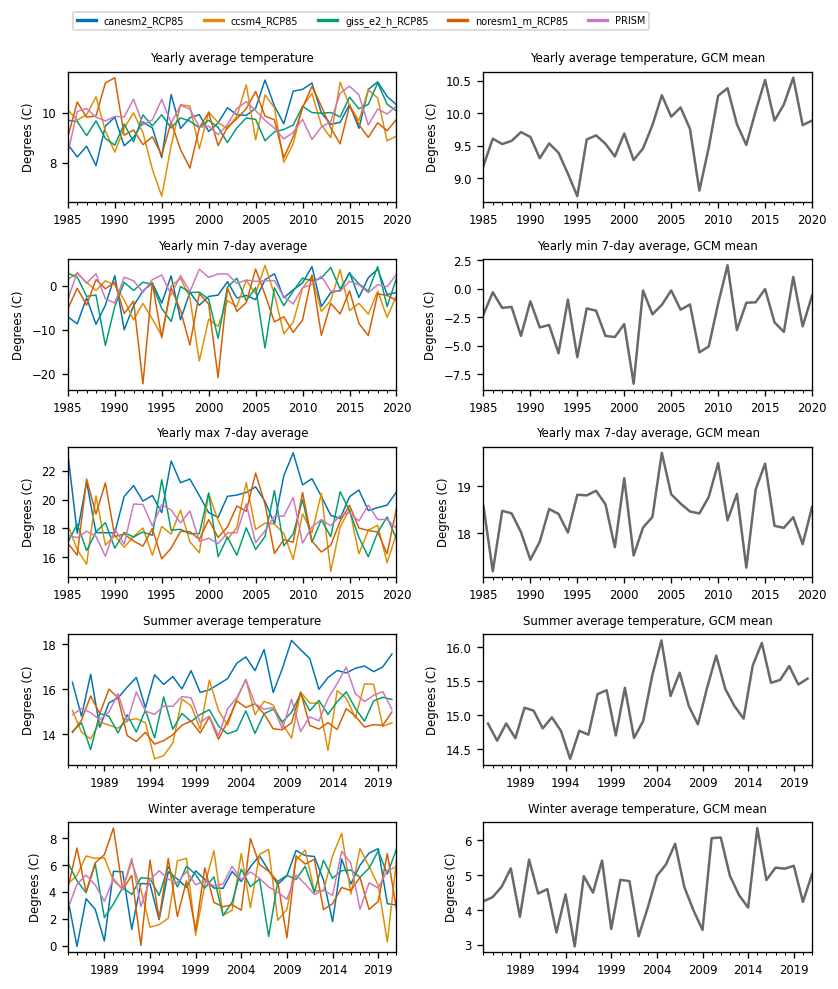

In [5]:
plt.close('all')
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(7, 8))
cmap = sns.color_palette('colorblind', len(gcms))
lim_factor = 0.5  # Padding value for min and max ylimits

leftcols = ['Yearly average temperature', 'Yearly min 7-day average', 'Yearly max 7-day average', 
            'Summer average temperature', 'Winter average temperature']
rightcols = ['{}, GCM mean'.format(x) for x in leftcols]
ylabs = np.repeat(['Degrees (C)' for x in leftcols], 2)

for i, scenario in enumerate(scenarios):
    z = [x.groupby(pd.Grouper(freq='M')).mean() for x in temp_files]
    temp_y_avg = pd.concat([x.groupby(pd.Grouper(freq='y')).mean() for x in z], axis=1)

    z = [x.groupby(pd.Grouper(freq='7d')).mean() for x in temp_files]
    yearly_7day_min = pd.concat([x.groupby(pd.Grouper(freq='y')).min() for x in z], axis=1)

    yearly_7day_max = pd.concat([x.groupby(pd.Grouper(freq='y')).max() for x in z], axis=1)

    z = [x.groupby(pd.Grouper(freq='Q-NOV')).mean() for x in temp_files]
    y = pd.concat([x for x in z], axis=1)
    summer_avg = y.iloc[2:, :].iloc[::4, :]
    
    z = [x.groupby(pd.Grouper(freq='Q-NOV')).mean() for x in temp_files]
    y = pd.concat([x for x in z], axis=1)
    winter_avg = y.iloc[4:, :].iloc[::4, :]

    dfs = []
    for df in [temp_y_avg, yearly_7day_min, yearly_7day_max, summer_avg, winter_avg]:
        df.columns = gcms
        df = df[(df.index.year >= sim_start.year+1)]
        dfs.append(df)
        
    for j, ax in enumerate(axes):
        dfs[j].plot(ax=axes[j, 0], linewidth=0.9, color=cmap)
        axes[j, 0].title.set_text(leftcols[j])
        dfs[j].mean(axis=1).plot(ax=axes[j, 1], label=scenario, color='dimgray')
        axes[j, 1].title.set_text(rightcols[j])
        axes[j, 0].get_legend().remove()

for i, ax in enumerate(axes.flat):
    ax.set_xlim([sim_start + pd.DateOffset(years=1), sim_end])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel(ylabs[i])

plt.tight_layout(rect=[0, 0, 1, 0.99])

# Prevent duplicate GCM labels (dict can only have unique keys)
handles, labels = axes[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = axes[0, 0].legend(by_label.values(), by_label.keys(), loc='upper left', 
                        bbox_to_anchor=(0, 1.5), fancybox=True, ncol=5, fontsize='small')
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

fig.savefig(out_dir / 'temperature.png', bbox_inches='tight', dpi=export_dpi)

### Precipitation

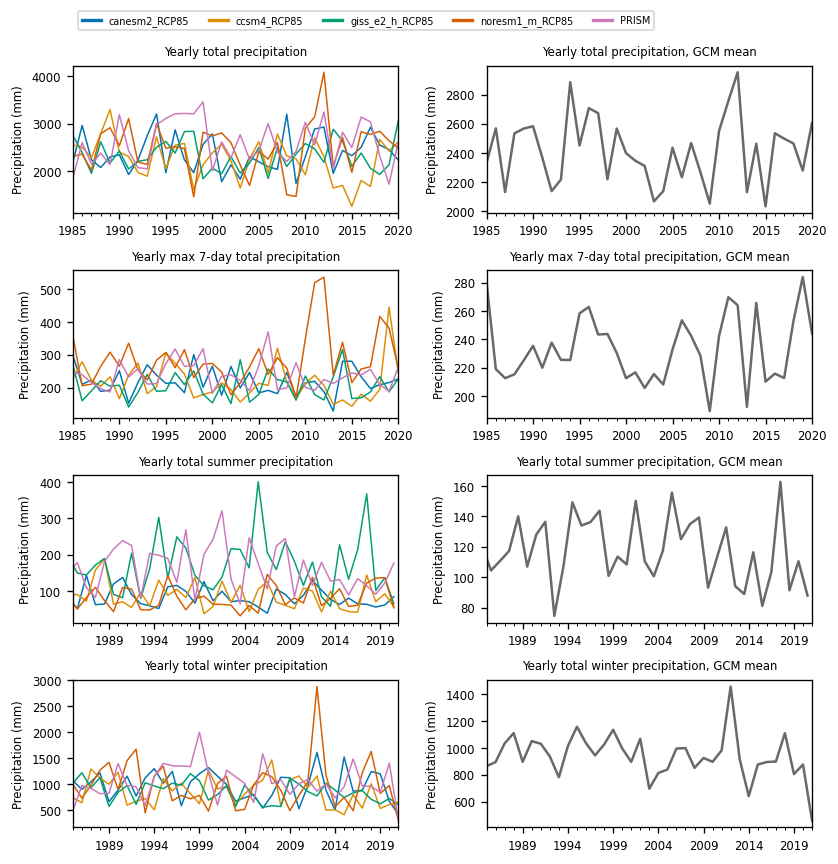

In [6]:
plt.close('all')
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(7, 7))
cmap = sns.color_palette('colorblind', len(gcms))
lim_factor = 0.5  # Padding value for min and max ylimits

leftcols = ['Yearly total precipitation', 'Yearly max 7-day total precipitation', 'Yearly total summer precipitation', 'Yearly total winter precipitation']
rightcols = ['{}, GCM mean'.format(x) for x in leftcols]
ylabs = np.repeat(['Precipitation (mm)' for x in leftcols], 2)

for i, scenario in enumerate(scenarios):
    z = [x.groupby(pd.Grouper(freq='Y')).sum() for x in precip_files]
    ppt_y_sum = pd.concat([x for x in z], axis=1)
    
    z = [x.groupby(pd.Grouper(freq='7d')).sum() for x in precip_files]
    yearly_7day_max = pd.concat([x.groupby(pd.Grouper(freq='y')).max() for x in z], axis=1)
    
    z = [x.groupby(pd.Grouper(freq='Q-NOV')).sum() for x in precip_files]
    y = pd.concat([x for x in z], axis=1)
    summer_sum = y.iloc[2:, :].iloc[::4, :]
    
    z = [x.groupby(pd.Grouper(freq='Q-NOV')).sum() for x in precip_files]
    y = pd.concat([x for x in z], axis=1)
    winter_sum = y.iloc[4:, :].iloc[::4, :]

    dfs = []
    for df in [ppt_y_sum, yearly_7day_max, summer_sum, winter_sum]:
        df.columns = gcms
        dfs.append(df)
        
    for j, ax in enumerate(axes):
        dfs[j].plot(ax=axes[j, 0], linewidth=0.9, color=cmap)
        axes[j, 0].title.set_text(leftcols[j])
        dfs[j].mean(axis=1).plot(ax=axes[j, 1], label=scenario, color='dimgray')
        axes[j, 1].title.set_text(rightcols[j])
        axes[j, 0].get_legend().remove()

for i, ax in enumerate(axes.flat):
    ax.set_xlim([sim_start + pd.DateOffset(years=1), sim_end])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel(ylabs[i])

plt.tight_layout(rect=[0, 0, 1, 0.99])

# Prevent duplicate GCM labels (dict can only have unique keys)
handles, labels = axes[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = axes[0, 0].legend(by_label.values(), by_label.keys(), loc='upper left', 
                        bbox_to_anchor=(0, 1.4), fancybox=True, ncol=5, fontsize='small')
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

fig.savefig(out_dir / 'precipitation.png', bbox_inches='tight', dpi=export_dpi)

## Runoff

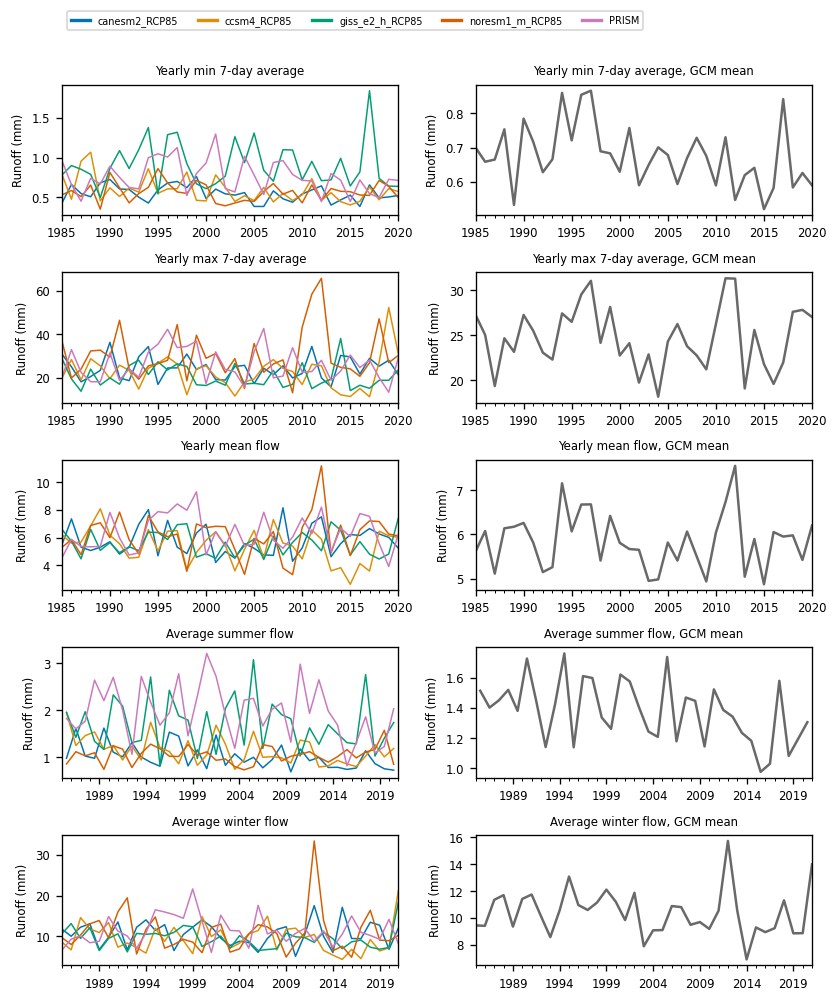

In [7]:
plt.close('all')
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(7, 8))
cmap = sns.color_palette('colorblind', len(gcms))
cmap_means = sns.color_palette('deep', len(scenarios))
lim_factor = 0.5  # Padding value for min and max ylimits

leftcols = ['Yearly min 7-day average', 'Yearly max 7-day average', 'Yearly mean flow', 'Average summer flow', 'Average winter flow']
rightcols = ['{}, GCM mean'.format(x) for x in leftcols]
ylabs = np.repeat(['Runoff (mm)' for x in leftcols], 2)

for i, scenario in enumerate(scenarios):
    z = [x.groupby(pd.Grouper(freq='7d')).mean()['Runoff_All(mm/day)_Delineated_Average'] for x in dailies[i]]
    yearly_7day_min = pd.concat([x.groupby(pd.Grouper(freq='y')).min() for x in z], axis=1)

    yearly_7day_max = pd.concat([x.groupby(pd.Grouper(freq='y')).max() for x in z], axis=1)

    z = [x.groupby(pd.Grouper(freq='y')).mean()['Runoff_All(mm/day)_Delineated_Average'] for x in dailies[i]]
    yearly_mean = pd.concat(z, axis=1)
    
    z = [x.groupby(pd.Grouper(freq='Q-NOV')).mean()['Runoff_All(mm/day)_Delineated_Average'] for x in dailies[i]]
    y = pd.concat([x for x in z], axis=1)
    summer_avg = y.iloc[2:, :].iloc[::4, :]
    
    z = [x.groupby(pd.Grouper(freq='Q-NOV')).mean()['Runoff_All(mm/day)_Delineated_Average'] for x in dailies[i]]
    y = pd.concat([x for x in z], axis=1)
    winter_avg = y.iloc[4:, :].iloc[::4, :]

    dfs = []
    for df in [yearly_7day_min, yearly_7day_max, yearly_mean, summer_avg, winter_avg]:
        df.columns = gcms
        df = df[(df.index.year >= sim_start.year+1)]
        dfs.append(df)
        
    for j, ax in enumerate(axes):
        dfs[j].plot(ax=axes[j, 0], linewidth=0.9, color=cmap)
        axes[j, 0].title.set_text(leftcols[j])
        dfs[j].mean(axis=1).plot(ax=axes[j, 1], label=scenario, color='dimgray')
        axes[j, 1].title.set_text(rightcols[j])
        axes[j, 0].get_legend().remove()

for i, ax in enumerate(axes.flat):
    ax.set_xlim([sim_start + pd.DateOffset(years=1), sim_end])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel(ylabs[i])

plt.tight_layout(rect=[0, 0, 1, 0.99])

# Prevent duplicate GCM labels (dict can only have unique keys)
handles, labels = axes[0, 0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))
leg = axes[0, 0].legend(by_label.values(), by_label.keys(), loc='upper left', 
                        bbox_to_anchor=(0, 1.6), fancybox=True, ncol=5, fontsize='small')
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

fig.savefig(out_dir / 'runoff.png', bbox_inches='tight', dpi=export_dpi)

## Stream temperature

In [8]:
# Get cell writer files

cell_results = []
for scenario in scenarios:
    cell_results_scenario = []
    scenario_dir = config.velma_data.parents[1] / 'results' / scenario
    for gcm in gcms:
        cell_paths = []
        results_dir = scenario_dir / 'ellsworth_{}_{}_{}_{}'.format(scenario,
                                                                    sim_start.year % 100,
                                                                    sim_end.year % 100,
                                                                    gcm)
        for file in os.listdir(results_dir):
            if file.startswith('Cell_'):
                cell_paths.append(file)
        
        nodes = []
        for path in cell_paths:
            nodes.append(path.split('_')[-1])
        
        cell_paths_sorted = [x for _,x in natsorted(zip(nodes,cell_paths))]
        
        for path in [cell_paths_sorted[0]]:  # Only need the first cell, which is the Ellsworth mouth/outlet
            cell_result = pd.read_csv(results_dir / path)
            jday_pad = cell_result['Jday'].apply(lambda x: str(x).zfill(3))
            str_year = cell_result['Year'].apply(lambda x: str(x))
            cell_result['date'] = str_year + jday_pad
            rng = pd.to_datetime(cell_result['date'], format='%Y%j')
            cell_result.index = rng
            cell_results_scenario.append(cell_result)
    
    cell_results.append(cell_results_scenario)

In [9]:
# Correct VELMA stream temperature seasonal bias using pre-trained regression model
# *** Not sure if this correction is still valid considering the non-linear seasonal changes of the climate projections ***

olsmodel = load_pickle(config.data_path.parents[0] / 'models' / 'stream_temp_correction_ols.pickle')

stream_temps_corrected = []
for i, scenario in enumerate(scenarios):
    stream_temps_scenario = []
    for j, gcm in enumerate(gcms):
        z = cell_results[i][j]['Water_Surface_Temperature(degrees_C)']
        
        day = 24 * 60 * 60
        year = 365.2425 * day
        timestamp_secs = pd.to_datetime(z.index)
        timestamp_secs = timestamp_secs.map(datetime.datetime.timestamp)
        year_cos = np.cos(timestamp_secs * (2 * np.pi / year))
        year_sin = np.sin(timestamp_secs * (2 * np.pi / year))

        y = pd.DataFrame(data=np.column_stack([z, year_cos, year_sin]), columns=['temp', 'year_cos', 'year_sin'])
        y.index = z.index
        y['air_temp_3day_avg'] = y['temp'].rolling(3, min_periods=0).mean()

        y = sm.add_constant(y)
        y['streamtemp_corrected'] = olsmodel.predict(y)
        
        stream_temps_scenario.append(y['streamtemp_corrected'])
    
    stream_temps_corrected.append(stream_temps_scenario)

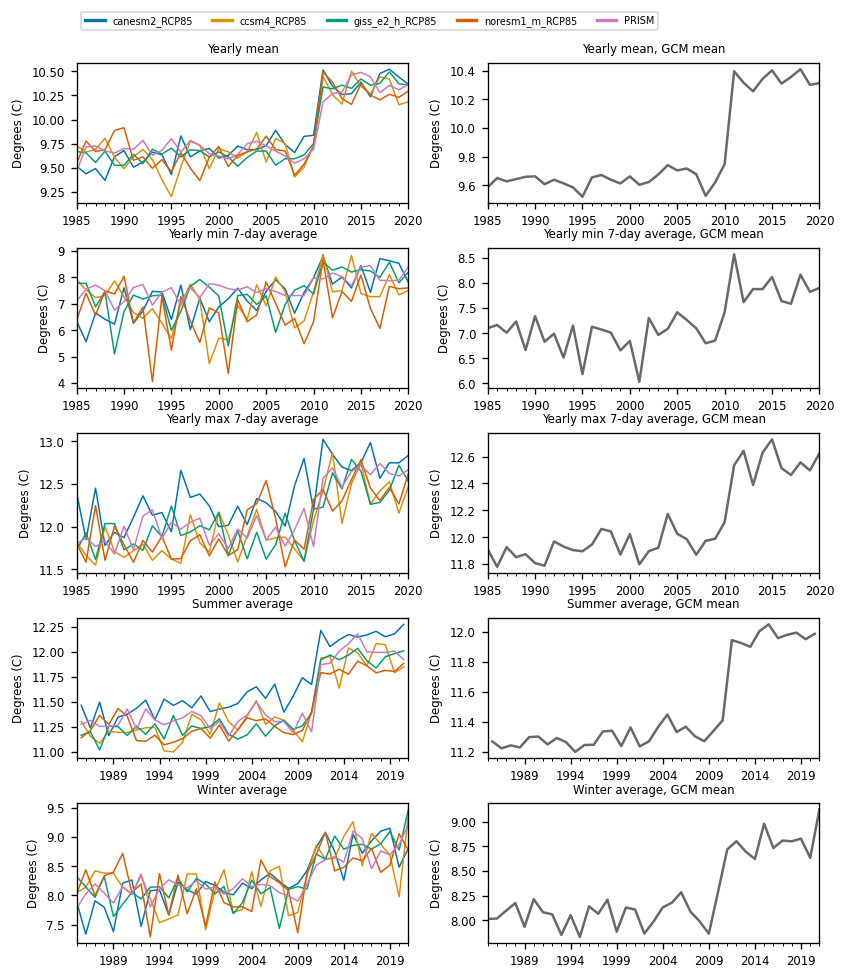

In [10]:
plt.close('all')
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(7, 8))
cmap = sns.color_palette('colorblind', len(gcms))
cmap_means = sns.color_palette('deep', len(scenarios))
lim_factor = 0.5  # Padding value for min and max ylimits

leftcols = ['Yearly mean', 'Yearly min 7-day average', 'Yearly max 7-day average', 
            'Summer average', 'Winter average']
rightcols = ['{}, GCM mean'.format(x) for x in leftcols]
ylabs = np.repeat(['Degrees (C)' for x in leftcols], 2)

for i, scenario in enumerate(scenarios):
    z = [x for x in stream_temps_corrected[i]]
    yearly_mean = pd.concat([x.groupby(pd.Grouper(freq='y')).mean() for x in z], axis=1)
    
    z = [x.groupby(pd.Grouper(freq='7d')).mean() for x in stream_temps_corrected[i]]
    yearly_7day_min = pd.concat([x.groupby(pd.Grouper(freq='y')).min() for x in z], axis=1)
    
    z = [x.groupby(pd.Grouper(freq='7d')).mean() for x in stream_temps_corrected[i]]
    yearly_7day_max = pd.concat([x.groupby(pd.Grouper(freq='y')).max() for x in z], axis=1)

    z = [x.groupby(pd.Grouper(freq='Q-NOV')).mean() for x in stream_temps_corrected[i]]
    y = pd.concat([x for x in z], axis=1)
    summer_avg = y.iloc[2:, :].iloc[::4, :]
    
    z = [x.groupby(pd.Grouper(freq='Q-NOV')).mean() for x in stream_temps_corrected[i]]
    y = pd.concat([x for x in z], axis=1)
    winter_avg = y.iloc[4:, :].iloc[::4, :]

    dfs = []
    for df in [yearly_mean, yearly_7day_min, yearly_7day_max, summer_avg, winter_avg]:
        df.columns = gcms
        df = df[(df.index.year >= sim_start.year+1)]
        dfs.append(df)
        
    for j, ax in enumerate(axes):
        dfs[j].plot(ax=axes[j, 0], linewidth=0.9, color=cmap)
        axes[j, 0].title.set_text(leftcols[j])
        dfs[j].mean(axis=1).plot(ax=axes[j, 1], label=scenario, color='dimgray')
        axes[j, 1].title.set_text(rightcols[j])
        axes[j, 0].get_legend().remove()

for i, ax in enumerate(axes.flat):
    ax.set_xlim([sim_start + pd.DateOffset(years=1), sim_end])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel(ylabs[i])

plt.tight_layout(rect=[0, 0, 1, 0.99], h_pad=0.01, w_pad=0.00)
leg = axes[0, 0].legend(loc='upper left', bbox_to_anchor=(0, 1.4), fancybox=True, ncol=5, fontsize='small')
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

fig.savefig(out_dir / 'stream_temperature.png', bbox_inches='tight', dpi=export_dpi)

## Stream chemistry

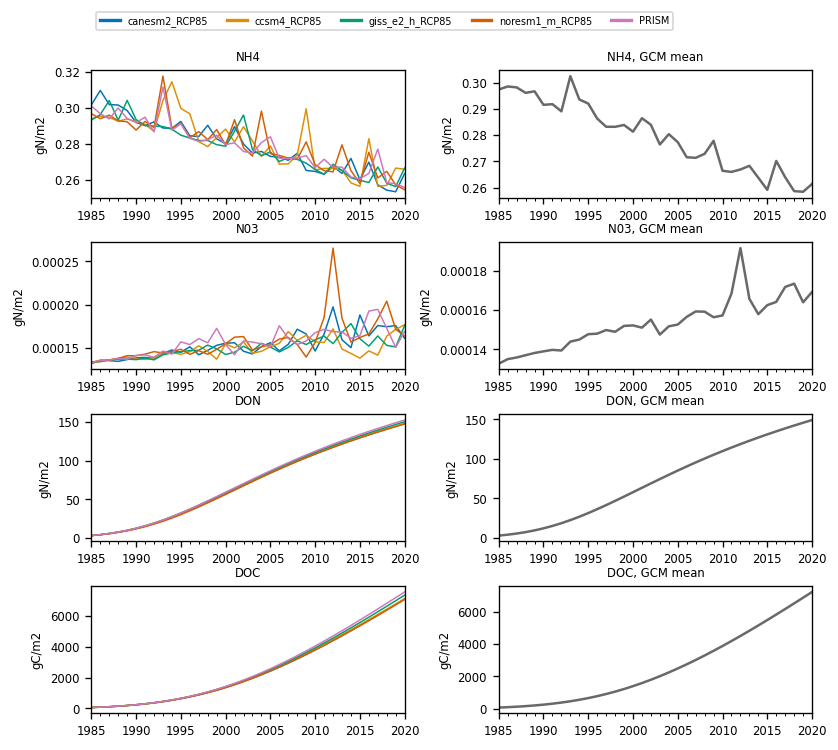

In [11]:
plt.close('all')
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(7, 6))
cmap = sns.color_palette('colorblind', len(gcms))
lim_factor = 0.5  # Padding value for min and max ylimits

leftcols = ['NH4', 'N03', 'DON', 'DOC']
rightcols = ['{}, GCM mean'.format(x) for x in leftcols]
ylabs = np.repeat(['gN/m2', 'gN/m2', 'gN/m2', 'gC/m2'], 2)

for i, scenario in enumerate(scenarios):
    z = [x[['NH4(gN/m2)_Layer1', 'NH4(gN/m2)_Layer2', 'NH4(gN/m2)_Layer3', 'NH4(gN/m2)_Layer4']].sum(axis=1) for x in cell_results[i]]
    nh4 = [x.groupby(pd.Grouper(freq='y')).mean() for x in z]

    z = [x[['NO3(gN/m2)_Layer1', 'NO3(gN/m2)_Layer2', 'NO3(gN/m2)_Layer3', 'NO3(gN/m2)_Layer4']].sum(axis=1) for x in cell_results[i]]
    no3 = [x.groupby(pd.Grouper(freq='y')).mean() for x in z]

    z = [x[['DON(gN/m2)_Layer1', 'DON(gN/m2)_Layer2', 'DON(gN/m2)_Layer3', 'DON(gN/m2)_Layer4']].sum(axis=1) for x in cell_results[i]]
    don = [x.groupby(pd.Grouper(freq='y')).mean() for x in z]

    z = [x[['DOC(gC/m2)_Layer1', 'DOC(gC/m2)_Layer2', 'DOC(gC/m2)_Layer3', 'DOC(gC/m2)_Layer4']].sum(axis=1) for x in cell_results[i]]
    doc = [x.groupby(pd.Grouper(freq='y')).mean() for x in z]

    dfs = []
    for df in [nh4, no3, don, doc]:
        df = pd.concat(df, axis=1)
        df.columns = gcms
        df = df[(df.index.year >= sim_start.year+1)]
        dfs.append(df)
        
    for j, ax in enumerate(axes):
        dfs[j].plot(ax=axes[j, 0], linewidth=0.9, color=cmap)
        axes[j, 0].title.set_text(leftcols[j])
        dfs[j].mean(axis=1).plot(ax=axes[j, 1], label=scenario, color='dimgray')
        axes[j, 1].title.set_text(rightcols[j])
        axes[j, 0].get_legend().remove()

for i, ax in enumerate(axes.flat):
    ax.set_xlim([sim_start + pd.DateOffset(years=1), sim_end])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel(ylabs[i])

plt.tight_layout(rect=[0, 0, 1, 0.99], h_pad=0.01, w_pad=0.00)
leg = axes[0, 0].legend(loc='upper left', bbox_to_anchor=(0, 1.5), fancybox=True, ncol=5, fontsize='small')
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

fig.savefig(out_dir / 'stream_chemistry.png', bbox_inches='tight', dpi=export_dpi)

# Carbon

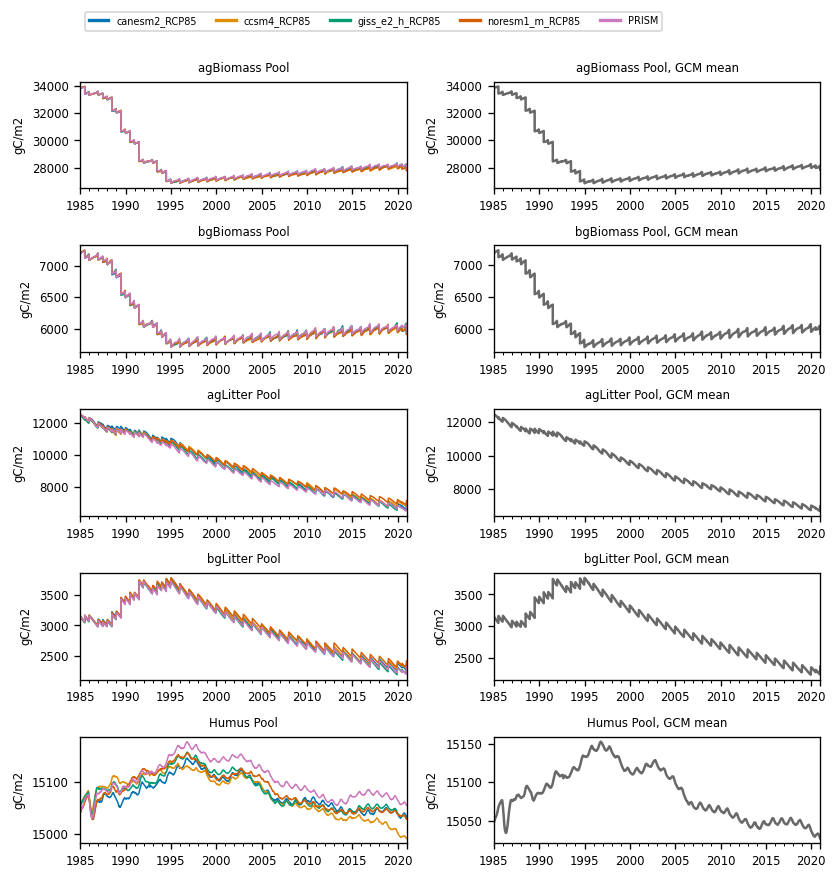

In [12]:
plt.close('all')
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(7, 7))
cmap = sns.color_palette('colorblind', len(gcms))
lim_factor = 0.5  # Padding value for min and max ylimits

leftcols = ['agBiomass Pool', 'bgBiomass Pool', 'agLitter Pool', 'bgLitter Pool', 'Humus Pool']
rightcols = ['{}, GCM mean'.format(x) for x in leftcols]
ylabs = np.repeat(['gC/m2' for x in leftcols], 2)

for i, scenario in enumerate(scenarios):
    ag_biomass_pool = [x['agBiomass_Pool(gC/m2)_Delineated_Average'] for x in dailies[i]]
    bg_biomass_pool = [x['bgBiomass_Pool(gC/m2)_Delineated_Average'] for x in dailies[i]]
    ag_litter_pool = [x['agLitter_Pool(gC/m2)_Delineated_Average'] for x in dailies[i]]
    bg_litter_pool = [x['bgLitter_Pool(gC/m2)_Delineated_Average'] for x in dailies[i]]
    humus_pool = [x['Humus_Pool(gC/m2)_Delineated_Average'] for x in dailies[i]]

    dfs = []
    for df in [ag_biomass_pool, bg_biomass_pool, ag_litter_pool, bg_litter_pool, humus_pool]:
        df = pd.concat(df, axis=1)
        df.columns = gcms
        df = df[(df.index.year >= sim_start.year+1)]
        dfs.append(df)
        
    for j, ax in enumerate(axes):
        dfs[j].plot(ax=axes[j, 0], linewidth=0.9, color=cmap)
        axes[j, 0].title.set_text(leftcols[j])
        dfs[j].mean(axis=1).plot(ax=axes[j, 1], label=scenario, color='dimgray')
        axes[j, 1].title.set_text(rightcols[j])
        axes[j, 0].get_legend().remove()

for i, ax in enumerate(axes.flat):
    ax.set_xlim([sim_start + pd.DateOffset(years=1), sim_end])
    ax.xaxis.label.set_visible(False)
    ax.set_ylabel(ylabs[i])

plt.tight_layout(rect=[0, 0, 1, 0.99])
leg = axes[0, 0].legend(loc='upper left', bbox_to_anchor=(0, 1.7), fancybox=True, ncol=5, fontsize='small')
for legobj in leg.legendHandles:
    legobj.set_linewidth(2.0)

fig.savefig(out_dir / 'biomass_carbon.png', bbox_inches='tight', dpi=export_dpi)